In [21]:
import geopandas
import matplotlib.pyplot as pyplot
from scipy import interpolate
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d, ConvexHull, convex_hull_plot_2d, KDTree
from scipy.spatial.distance import euclidean
import numpy as np
import math
# %matplotlib inline

In [6]:
berlinDistricts = geopandas.read_file("../shared/berlinDistricts.geojson")
measurements = geopandas.read_file("data/data_2020-02-20T11-01-00.geojson")

berlinDistricts = berlinDistricts.to_crs(epsg=3068)
measurements = measurements.to_crs(epsg=3068)

pyplot.rcParams['figure.figsize'] = 30, 20
pyplot.rcParams['font.size'] = 20
pyplot.rcParams['axes.titlesize'] = 50
pyplot.rcParams['axes.titlepad'] = 80


In [5]:
berlinPlot = berlinDistricts.boundary.plot(edgecolor="black")
berlinPlot.set_title("Berlin Districts with Measurements")
measurements.plot(ax=berlinPlot, column="value", legend=True)

berlinPlot.figure.savefig("measurements-in-berlin.png")

In [17]:
x = np.array(measurements.geometry.x)
y = np.array(measurements.geometry.y)
points = np.column_stack((x,y))
values = np.array(measurements.value)

In [16]:
interpolator = interpolate.interp2d(x, y, values, kind="cubic")

xmin, ymin, xmax, ymax = measurements.total_bounds
xnew = np.linspace(xmin, xmax, 100)
ynew = np.linspace(ymin, ymax, 100)

valuesnew = interpolator(xnew, ynew)

In [7]:
# pyplot.pcolor(xnew, ynew, valuesnew)

In [10]:
voronoi = Voronoi(points)
# berlinPlot = berlinDistricts.boundary.plot(edgecolor="black")
# voronoi_plot_2d(vor, ax=berlinPlot, show_vertices=False, show_points=True, line_colors='orange')

In [9]:
delauny = Delaunay(points)
# berlinPlot = berlinDistricts.boundary.plot(edgecolor="black")
# delaunay_plot_2d(delauny, ax=berlinPlot)

In [10]:
convex = ConvexHull(points)
# berlinPlot = berlinDistricts.boundary.plot(edgecolor="black")
# convex_hull_plot_2d(convex, ax=berlinPlot)

In [39]:
def getMeasurementValue(value):
    zones = [[0,20], [20,40], [40,60], [60, math.inf]]
    for i, zone in enumerate(zones):
        if value >= zone[0] and value < zone[1]:
            return zone[0]

In [12]:
# Nearest Neighbor
def nearestNeighborInterpolator(x, y):
    nntree = KDTree(points)

    xx,yy = np.meshgrid(x,y)
    pointMatrix = np.dstack((xx,yy))
    result = []

    for row in pointMatrix:
        distances, indices = nntree.query(row)

        result.append(list(map(lambda idx: getMeasurementValue(values[idx]))))
    return np.array(result)


nnValues = nearestNeighborInterpolator(xnew, ynew)

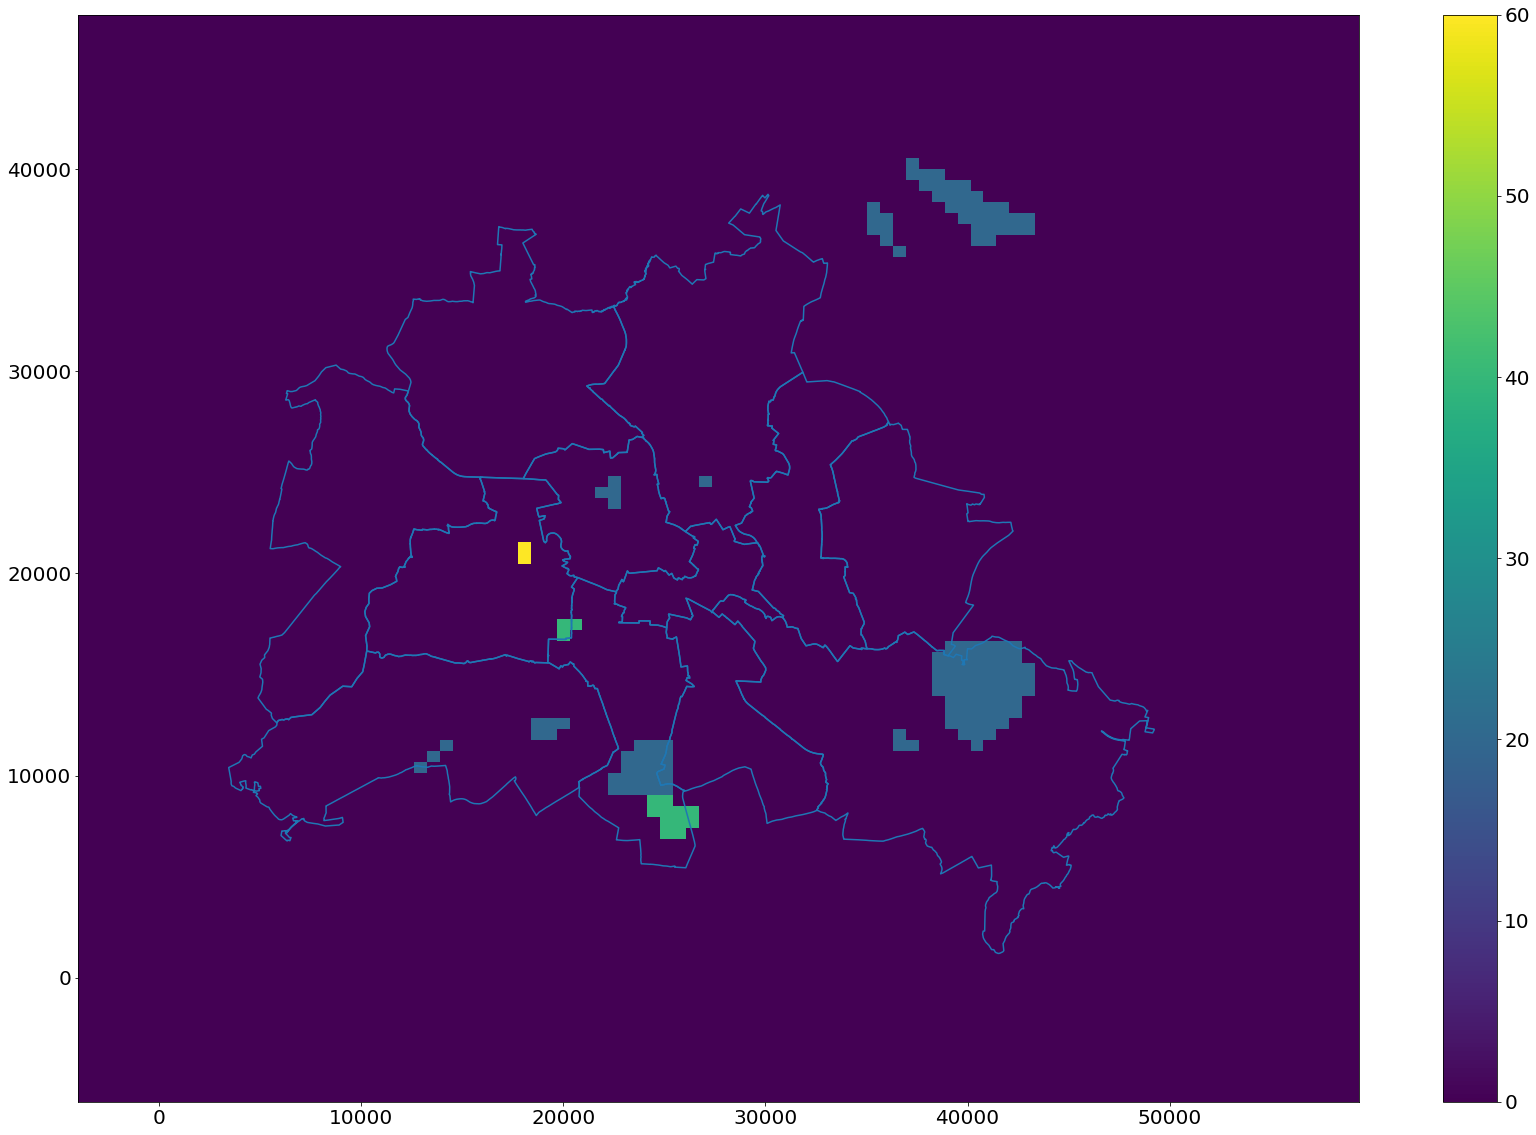

In [17]:
fig, ax = pyplot.subplots()
berlinDistricts.boundary.plot(ax=ax)
mash = ax.pcolormesh(xnew,ynew,nnValues)
fig.colorbar(mash, ax=ax)
pyplot.savefig("nearest-neighbor-with-zone.png")

In [40]:
# Inverse Distance Weighting

def inverseDistanceWeightingInterpolator(x, y, p):
    xx,yy = np.meshgrid(x,y)
    pointMatrix = np.dstack((xx,yy))
    result = []

    weights = []
    for row in pointMatrix:
        resultRow = []
        for fakePoint in row:
            inverseDistances = np.array([1/np.power(euclidean(fakePoint, realPoint), p) for realPoint in points])
            summedInverseDistances = np.sum(inverseDistances)
            weights = (inverseDistances/summedInverseDistances)
            resultRow.append(getMeasurementValue(np.sum(weights*values)))
        result.append(resultRow)

    return np.array(result)

idwValues = inverseDistanceWeightingInterpolator(xnew, ynew, 2)

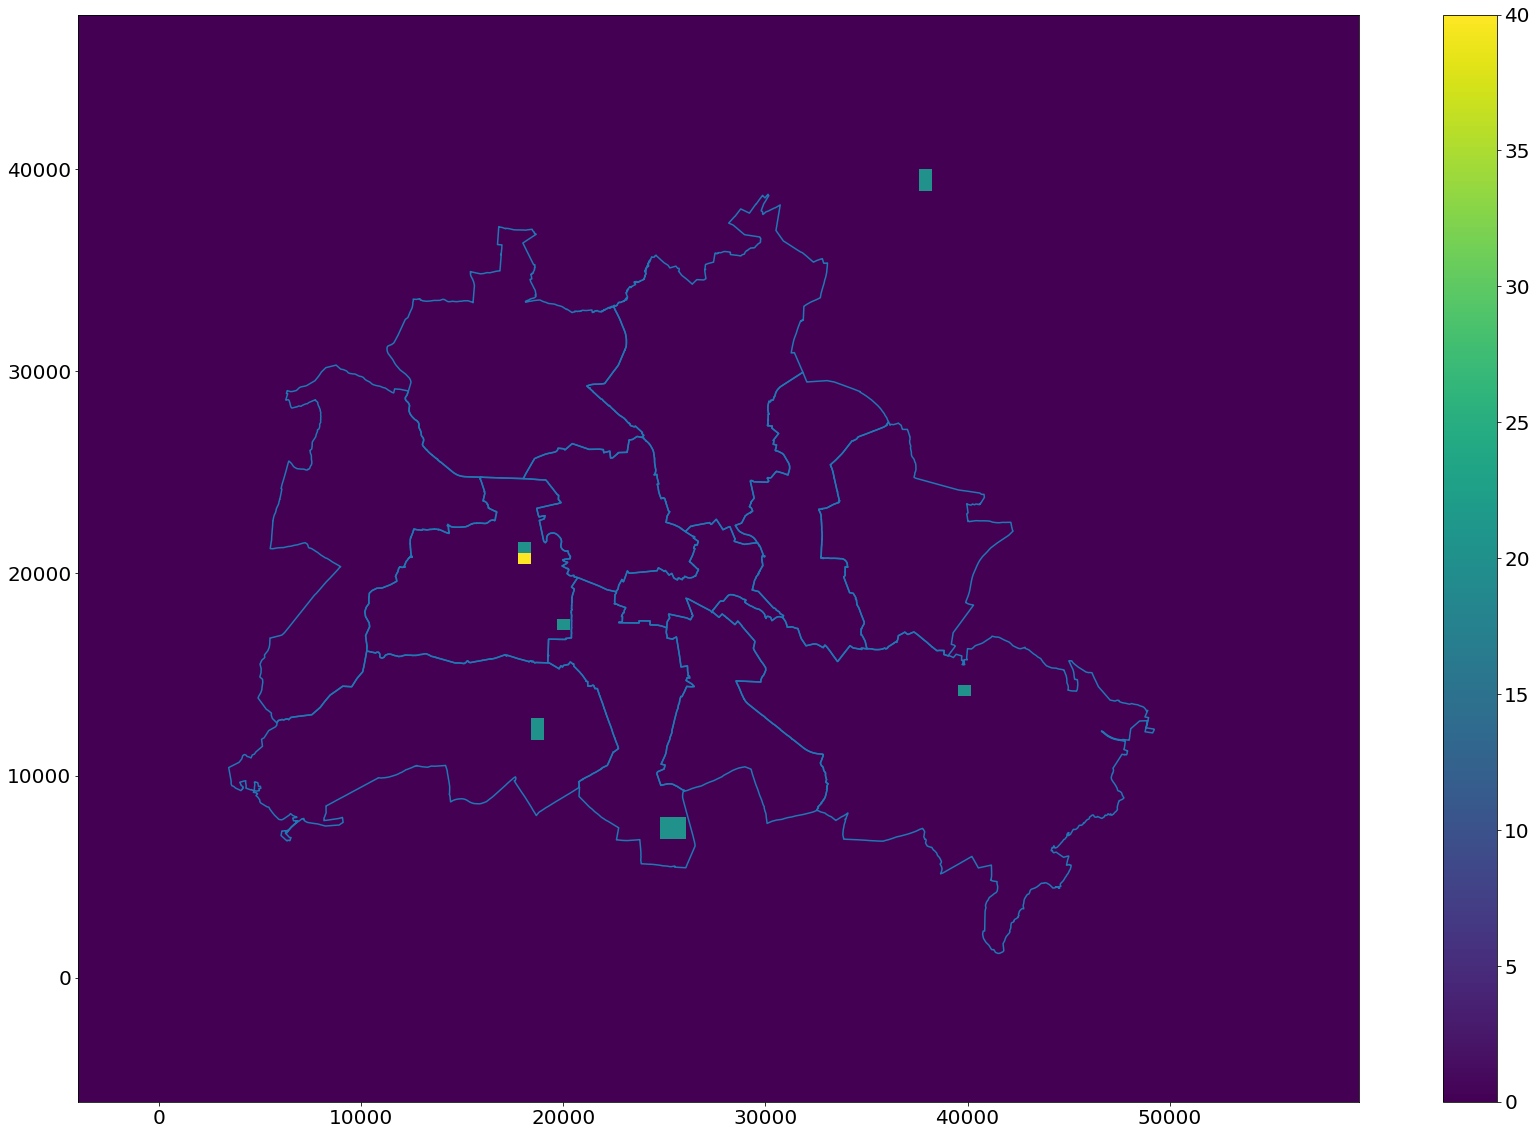

In [41]:
fig, ax = pyplot.subplots()
berlinDistricts.boundary.plot(ax=ax)
mash = ax.pcolormesh(xnew,ynew,idwValues)
fig.colorbar(mash, ax=ax)
pyplot.savefig("inverse-distance-weighting-with-zones.png")